In [1]:
# Downloading and importing all the necessary libraries to complete the project.
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import json
import os
import re
import warnings
warnings.simplefilter('ignore')


In [2]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
pd.set_option('display.max_colwidth', -1)

## Data Gathering of three files (archive-downloaded manually,json tweet-uploaded, image prediction-from url and downloaded programmatically)

##### First table archive downloaded from the internet manually and programmatically opened into a pandas DataFrame.

In [4]:
archive = pd.read_csv('twitter-archive-enhanced-2.csv')

In [5]:
from tweepy import OAuthHandler
from timeit import default_timer as timer

%%script false 
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = archive.tweet_id.values
len(tweet_ids)

In [ ]:
# set a function for tweet extraction
# file already created so no need to execute to continue the notebook
def tweet_extraction():
    count = 0
    fails_dict = {}
    start = timer()
    with open('tweet_json.txt', 'w') as outfile:
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

##### Second data a JSON file down downloaded from the Udacity servers then uploaded to the workspace environment, stored in a dictionary, then loaded into a pandas DataFrame.

In [6]:
df_list = []
with open('tweet_json.txt') as file:
    for line in file:
        data = json.loads(line)
        keys = data.keys()
        user = data.get('user')
        id_str = data.get('id_str')
        retweet_count = data.get('retweet_count')
        favorite_count = data.get('favorite_count')
        df_list.append({'id_str': id_str,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})

In [7]:
tweet_count = pd.DataFrame(df_list, columns = ['id_str', 'retweet_count', 'favorite_count'])

##### Third table, programmatically downloaded from the Udacity servers and stored in a folder image_pred, then written to local computer and loaded into a pandas DataFrame.

In [8]:
# Downloading the image predictions from the internet
folder_name = 'image_pred'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [9]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [10]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [11]:
image_pred =pd.read_csv('image_pred/image-predictions.tsv',sep="\t")

## Data Assessment , data expolre and detect any issues/inconsistency

### Visual

In [ ]:
archive.head()

In [12]:
archive.text.sample(20)

407     This is Winston. The goggles make him a superhero. Protects the entire city from criminals unless they rub his belly really well. 12/10 https://t.co/yCydYURYEL     
1691    This is Glacier. He's a very happy pup. Loves to sing in the sunlight. 11/10 https://t.co/jTBPqKgkz7                                                                
2270    Say hello to Hall and Oates. Oates is winking and Hall is contemplating the artistic entropy of the universe. 11/10s https://t.co/n5Wtb5Hvsl                        
843     His name is Charley and he already has a new set of wheels thanks to donations. I heard his top speed was also increased. 13/10 for Charley                         
1372    I know it's tempting, but please stop sending in pics of Donald Trump. Thank you ...9/10 https://t.co/y35Y1TJERY                                                    
2299    Here we have a Hufflepuff. Loves vest. Eyes wide af. Flaccid tail. Matches carpet. Always a little blurry. 8/10 https://t.co/7J

In [13]:
tweet_count.head()

,id_str,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [14]:
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## tweet id

In [15]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
doggo = archive.doggo.value_counts()
floofer = archive.floofer.value_counts()
pupper = archive.pupper.value_counts()
puppo = archive.puppo.value_counts()
print(doggo); 
print(floofer); 
print(pupper); 
print(puppo)

None     2259
doggo    97  
Name: doggo, dtype: int64
None       2346
floofer    10  
Name: floofer, dtype: int64
None      2099
pupper    257 
Name: pupper, dtype: int64
None     2326
puppo    30  
Name: puppo, dtype: int64


##### Missing information for the dog stages

In [17]:
archive.name.value_counts().head(20)

None       745
a          55 
Charlie    12 
Cooper     11 
Lucy       11 
Oliver     11 
Tucker     10 
Lola       10 
Penny      10 
Winston    9  
Bo         9  
the        8  
Sadie      8  
Bailey     7  
Toby       7  
Buddy      7  
an         7  
Daisy      7  
Koda       6  
Bella      6  
Name: name, dtype: int64

##### Many missing names from the list under 'None', and random names like 'a' and 'an' might be parts of strings that got taken out of context.

In [18]:
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

##### The source column looks messy and clutters the table

In [19]:
tweet_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id_str            2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


##### The column id_str should be changed to tweet_id so merging tables will be smoother.

In [20]:
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


##### The tweet_id column should be dtype object instead of int64.

In [21]:
# trimmed the names in order to make less wordy when coding
archive_clean = archive.copy()
image_clean = image_pred.copy()
tweet_clean = tweet_count.copy()

### 1 archive: remove from table retweets and replies keeping only original tweets

### Define

#### Find the retweets and replies using the retweeted_status_id and in_reply_to_status_id columns and remove from the DataFrame

### Code 

In [22]:
drop_retweet = archive_clean[pd.notnull(archive_clean['retweeted_status_id'])].index
drop_reply = archive_clean[pd.notnull(archive_clean['in_reply_to_status_id'])].index

In [23]:
archive_clean.drop(index=drop_retweet, inplace=True)
archive_clean.drop(index=drop_reply, inplace=True)

#### Test

In [24]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)


### 2 archive: Missing values in columns and unnecessary columns

### Define

#### Remove columns with missing values using dropna() method. Also, use the drop() method to drop source column from table as well

### Code

In [25]:
archive_clean.dropna(axis='columns',how='any', inplace=True)

In [26]:
archive_clean.drop(columns='source', inplace=True)

Test

In [27]:
archive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,None,None,None,None


### 3 Fixing Column Names

### Define

#### In the tweet_clean table the column name id_str changed to tweet_id using the rename() function.
#### In the archive_clean table, column name floofer should be "floof" to match the dog stage associated with it using the rename() function. The columns rating_numerator and rating_denominator should be shortend to "rate_num" and "rate_denom" to make it less wordy.

### Code

In [28]:
tweet_clean.rename(index=str, columns={"id_str": "tweet_id"}, inplace=True)
archive_clean.rename(columns={"floofer": "floof", 
                                         "rating_numerator": "rate_num",
                                         "rating_denominator": "rate_denom"}, inplace=True)

### Test

In [29]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 73.6+ KB


In [30]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id      2097 non-null int64
timestamp     2097 non-null object
text          2097 non-null object
rate_num      2097 non-null int64
rate_denom    2097 non-null int64
name          2097 non-null object
doggo         2097 non-null object
floof         2097 non-null object
pupper        2097 non-null object
puppo         2097 non-null object
dtypes: int64(3), object(7)
memory usage: 180.2+ KB


### 4 Fixing Datatypes

#### In the image_clean table, change the dtype of column tweet_id from int64 to object using the astype() function.
#### In the archive_clean table, change the dtype of column timestamp from object to datetime using pandas to_datetime() function.
#### In the archive_clean table, change the dtype of column tweet_id from int64 to object using the astype() function.

### Define

##### In the image_clean table, change the dtype of column tweet_id from int64 to object using the astype() function.
##### In the archive_clean table, change the dtype of column timestamp from object to datetime using pandas to_datetime() function.
##### In the archive_clean table, change the dtype of column tweet_id from int64 to object using the astype() function.

### Code

In [31]:
image_clean['tweet_id'] = image_clean['tweet_id'].astype('str')
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])
archive_clean['tweet_id'] = archive_clean['tweet_id'].astype('str')

### Test

In [32]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [33]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id      2097 non-null object
timestamp     2097 non-null datetime64[ns]
text          2097 non-null object
rate_num      2097 non-null int64
rate_denom    2097 non-null int64
name          2097 non-null object
doggo         2097 non-null object
floof         2097 non-null object
pupper        2097 non-null object
puppo         2097 non-null object
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 180.2+ KB


### 5 image_clean: dog breeds uniformity

### Define

#### In the image_clean table, the dogbreeds in the p1, p2, and p3 are converting all the names to lowercase letters.

### Code

In [34]:
image_clean['p1'] = image_clean['p1'].str.lower()
image_clean['p2'] = image_clean['p2'].str.lower()
image_clean['p3'] = image_clean['p3'].str.lower()

#### Test

In [35]:
image_clean.p1.head()

0    welsh_springer_spaniel
1    redbone               
2    german_shepherd       
3    rhodesian_ridgeback   
4    miniature_pinscher    
Name: p1, dtype: object

In [36]:
image_clean.p2.head()

0    collie            
1    miniature_pinscher
2    malinois          
3    redbone           
4    rottweiler        
Name: p2, dtype: object

In [37]:
image_clean.p3.head()

0    shetland_sheepdog  
1    rhodesian_ridgeback
2    bloodhound         
3    miniature_pinscher 
4    doberman           
Name: p3, dtype: object

### 6 archive_clean: clean up text column

### Define

#### In the archive_clean table, change the html ampersand code from "&amp ;" to "&" in the text column
#### Remove the "/n " the newline symbol
#### Remove ending url link.

In [ ]:
### Code

In [38]:
archive_clean['text'] = archive_clean.text.str.replace("&amp;", "&")
archive_clean['text'] = archive_clean.text.str.replace("\n", " ")
archive_clean['text'] = archive_clean.text.str.replace(r"http\S+", "")
archive_clean['text'] = archive_clean.text.str.strip()

#### Test

In [39]:
archive_clean.query("text == '&amp;'")

,tweet_id,timestamp,text,rate_num,rate_denom,name,doggo,floof,pupper,puppo


In [40]:
archive_clean.iloc[[588, 797, 853, 948, 985, 1005, 1136, 1234, 1239, 1278, 
                    1294, 1307, 1426, 1556, 1592, 1649, 1653, 1719, 1759, 
                    1811, 1860, 1922, 1960, 2005, 2014, 2047, 2076], [2,3,4,5]]

,text,rate_num,rate_denom,name
766,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing",12,10,None
1007,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively,10,10,Bookstore
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11,None
1165,Happy 4/20 from the squad! 13/10 for all,4,20,None
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50,Bluebert
1222,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 & 8/10 get it together Flurp,10,10,Travis
1359,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10,9,10,Socks
1459,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_)",4,10,None
1465,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random & can't bark for shit. 10/10 & 5/10,10,10,Oliviér
1508,When bae says they can't go out but you see them with someone else that same night. 5/10 & 10/10 for heartbroken pup,5,10,None


### 7 archive_clean: fix some of the ratings columns

### Define

#### In the archive_clean table, use several methods such as extractall(), query(), contains(), etc to check for misextraction of the ratings.

### Code

In [41]:
archive_clean.reset_index(inplace=True, drop=True)

In [42]:
archive_clean[archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rate_num']]

,text,rate_num
41,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",5
528,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75
586,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27
1474,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26


In [43]:
hyphen_table = archive_clean.text.str.extractall(r"(\d+\d*\/\d+)")
hyphen_table.head(10)

,,0
,match,
0,0,13/10
1,0,13/10
2,0,12/10
3,0,13/10
4,0,12/10
5,0,13/10
6,0,13/10
7,0,13/10
8,0,13/10


In [44]:
match_1 = hyphen_table.query("match == 1")
match_1.head()

,,0
,match,
588,1,11/10
797,1,7/10
853,1,14/10
948,1,13/10
985,1,11/10


In [45]:
match_1.index.labels

FrozenList([[588, 797, 853, 948, 985, 1005, 1136, 1234, 1239, 1278, 1294, 1307, 1426, 1556, 1592, 1649, 1653, 1719, 1759, 1811, 1860, 1922, 1960, 2005, 2014, 2047, 2076], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [46]:
# copied indices from above
archive_clean.iloc[[588, 797, 853, 948, 985, 1005, 1136, 1234, 1239, 1278, 
                    1294, 1307, 1426, 1556, 1592, 1649, 1653, 1719, 1759, 
                    1811, 1860, 1922, 1960, 2005, 2014, 2047, 2076], [2,3,4,5]]

,text,rate_num,rate_denom,name
588,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing",12,10,None
797,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively,10,10,Bookstore
853,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11,None
948,Happy 4/20 from the squad! 13/10 for all,4,20,None
985,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50,Bluebert
1005,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 & 8/10 get it together Flurp,10,10,Travis
1136,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10,9,10,Socks
1234,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_)",4,10,None
1239,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random & can't bark for shit. 10/10 & 5/10,10,10,Oliviér
1278,When bae says they can't go out but you see them with someone else that same night. 5/10 & 10/10 for heartbroken pup,5,10,None


In [47]:
#rating confused with 9/11(September 11th)
archive_clean.iloc[853, 3] = 14
archive_clean.iloc[853, 4] = 10

#rating confused with 4/20(Weed Day)
archive_clean.iloc[948, 3] = 13
archive_clean.iloc[948, 4] = 10

#rating confused with phrase 50/50 split
archive_clean.iloc[985, 3] = 11
archive_clean.iloc[985, 4] = 10

#rating confused with 7/11 which is name of convience store
archive_clean.iloc[1426, 3] = 10
archive_clean.iloc[1426, 4] = 10

#rating confused with 1/2 representing "half"
archive_clean.iloc[2076, 3] = 9
archive_clean.iloc[2076, 4] = 10

In [48]:
doubles_list = archive_clean.iloc[[588, 797, 1005, 1136, 1234, 1239, 1278, 
                    1294, 1307, 1556, 1592, 1649, 1653, 1719, 1759, 
                    1811, 1860, 1922, 1960, 2005, 2014, 2047]]
double_index = doubles_list.index

### Test

In [49]:
archive_clean.iloc[[41, 528, 586, 1474], [2,3,4]]

,text,rate_num,rate_denom
41,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",5,10
528,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75,10
586,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27,10
1474,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26,10


In [50]:
archive_clean.iloc[41, 3] = 13.5
archive_clean.iloc[528, 3] = 9.75
archive_clean.iloc[586, 3] = 11.27
archive_clean.iloc[1474, 3] = 11.26

In [51]:
archive_clean.iloc[[45, 528, 586, 1474], [2,3,4]]

,text,rate_num,rate_denom
45,This is Gus. He's quite the cheeky pupper. Already perfected the disinterested wink. 12/10 would let steal my girl,12.00,10
528,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",9.75,10
586,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,11.27,10
1474,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,11.26,10


In [52]:
archive_clean.iloc[[853, 948, 985, 1426, 2076], [2,3,4,5]]

,text,rate_num,rate_denom,name
853,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",14.0,10,None
948,Happy 4/20 from the squad! 13/10 for all,13.0,10,None
985,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,11.0,10,Bluebert
1426,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10,10.0,10,Darrel
2076,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10,9.0,10,an


### 8 archive_clean: removing. doubles

### Define

#### In the archive_clean table, there are some tweets with two dogs being rated, therefore those will be dropped because it violates the rules of tidiness..

### Code

In [53]:
doubles_list = archive_clean.iloc[[588, 797, 1005, 1136, 1234, 1239, 1278, 
                    1294, 1307, 1556, 1592, 1649, 1653, 1719, 1759, 
                    1811, 1860, 1922, 1960, 2005, 2014, 2047]]
double_index = doubles_list.index

In [54]:
archive_clean.drop(axis='index', index=double_index, inplace=True)

#### Test

In [55]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2096
Data columns (total 10 columns):
tweet_id      2075 non-null object
timestamp     2075 non-null datetime64[ns]
text          2075 non-null object
rate_num      2075 non-null float64
rate_denom    2075 non-null int64
name          2075 non-null object
doggo         2075 non-null object
floof         2075 non-null object
pupper        2075 non-null object
puppo         2075 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 178.3+ KB


## Tidiness

### 1 MERGE

### Define

#### Take both the archive_clean and tweet_clean tables and merge into one table using the join() method on the columns tweet_id.

### Code

In [56]:
df_merge1 = archive_clean.join(tweet_clean.set_index('tweet_id'), on='tweet_id')

#### Test

In [57]:
df_merge1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2096
Data columns (total 12 columns):
tweet_id          2075 non-null object
timestamp         2075 non-null datetime64[ns]
text              2075 non-null object
rate_num          2075 non-null float64
rate_denom        2075 non-null int64
name              2075 non-null object
doggo             2075 non-null object
floof             2075 non-null object
pupper            2075 non-null object
puppo             2075 non-null object
retweet_count     2075 non-null int64
favorite_count    2075 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 210.7+ KB


### 2 Final Merge

### Define

#### Take the newly df_merge1 table and combine with the image_clean table using the same join() method on the tweet_id column.

### Code

In [58]:
master = df_merge1.join(image_clean.set_index('tweet_id'), on='tweet_id')

#### Test

In [59]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2096
Data columns (total 23 columns):
tweet_id          2075 non-null object
timestamp         2075 non-null datetime64[ns]
text              2075 non-null object
rate_num          2075 non-null float64
rate_denom        2075 non-null int64
name              2075 non-null object
doggo             2075 non-null object
floof             2075 non-null object
pupper            2075 non-null object
puppo             2075 non-null object
retweet_count     2075 non-null int64
favorite_count    2075 non-null int64
jpg_url           1949 non-null object
img_num           1949 non-null float64
p1                1949 non-null object
p1_conf           1949 non-null float64
p1_dog            1949 non-null object
p2                1949 non-null object
p2_conf           1949 non-null float64
p2_dog            1949 non-null object
p3                1949 non-null object
p3_conf           1949 non-null float64
p3_dog            1949 no

#### Missing Data

### Define

##### ### Removing the missing rows from the merged tables using the drop() method.

### Code

In [60]:
master_copy = master.copy()

In [61]:
drop_index = master_copy[pd.isnull(master_copy['jpg_url'])].index
drop_index2 = master_copy[pd.isnull(master_copy['retweet_count'])].index
drop_index, drop_index2

(Int64Index([  32,   38,   65,   73,   78,   95,  113,  153,  155,  193,
             ...
             1505, 1512, 1522, 1537, 1552, 1568, 1579, 1594, 1666, 1956],
            dtype='int64', length=126), Int64Index([], dtype='int64'))

In [62]:
master_copy.drop(index=drop_index, inplace=True)
master_copy.drop(index=drop_index2, inplace=True)

#### Test

In [63]:
master_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1949 entries, 0 to 2096
Data columns (total 23 columns):
tweet_id          1949 non-null object
timestamp         1949 non-null datetime64[ns]
text              1949 non-null object
rate_num          1949 non-null float64
rate_denom        1949 non-null int64
name              1949 non-null object
doggo             1949 non-null object
floof             1949 non-null object
pupper            1949 non-null object
puppo             1949 non-null object
retweet_count     1949 non-null int64
favorite_count    1949 non-null int64
jpg_url           1949 non-null object
img_num           1949 non-null float64
p1                1949 non-null object
p1_conf           1949 non-null float64
p1_dog            1949 non-null object
p2                1949 non-null object
p2_conf           1949 non-null float64
p2_dog            1949 non-null object
p3                1949 non-null object
p3_conf           1949 non-null float64
p3_dog            1949 no

In [64]:
master_copy.to_csv(path_or_buf='master.csv', index=False)

In [65]:
master_clean = master_copy[['timestamp','tweet_id', 'rate_num', 'rate_denom', 
                            'name', 'retweet_count', 'favorite_count', 'p1', 'p2', 'p3']]

## Analyzing the Data

#### Now we need to take the final DataFrame and set the index to the timestamp column in order to gather some time series analysis. Twitter data is very time specific and would be nice visually to see changes over time.

In [66]:
#setting the DataFrame to index the timestamp column
master_copy = master_copy.set_index('timestamp')

In [67]:
master_copy.sample(5)

,tweet_id,text,rate_num,rate_denom,name,doggo,floof,pupper,puppo,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-24 02:02:12,679844490799091713,This is Willie. He's floating away and needs your assistance. Please someone help Willie. 10/10,10.0,10,Willie,None,None,None,None,887,...,1.0,airedale,0.903832,True,border_terrier,0.034713,True,toy_poodle,0.021378,True
2015-12-14 22:46:41,676533798876651520,ITSOFLUFFAYYYYY 12/10,12.0,10,None,None,None,None,None,621,...,1.0,chow,0.265274,True,ice_bear,0.167614,False,fur_coat,0.117506,False
2016-02-09 02:07:12,696877980375769088,This is Misty. She's in a predicament. Not sure what next move should be. 9/10 stay calm pupper I'm comin,9.0,10,Misty,None,None,pupper,None,802,...,1.0,space_heater,0.206876,False,spatula,0.123450,False,vacuum,0.119218,False
2017-02-02 01:01:21,826958653328592898,This is Loki. He smiles like Elvis. Ain't nothin but a hound doggo. 12/10,12.0,10,Loki,doggo,None,None,None,5757,...,1.0,golden_retriever,0.617389,True,labrador_retriever,0.337053,True,tennis_ball,0.008554,False
2016-06-25 00:56:43,746507379341139972,This is Shiloh. She did not pass the soft mouth egg test. 10/10 would absolutely still pet,10.0,10,Shiloh,None,None,None,None,1226,...,1.0,toy_poodle,0.508292,True,lakeland_terrier,0.234458,True,affenpinscher,0.084563,True


#### Basic Statistics

In [68]:
# viewing some descriptive statistics with the quantitative measures in our analysis. 
# used round(5) in order to visually see the last two columns without scientific notation involved.
master_copy.describe().round(5)

,rate_num,rate_denom,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,1949.00000,1949.00000,1949.00000,1949.00000,1949.00000,1949.00000,1949.00000,1949.00000
mean,12.20615,10.46024,2806.91534,9023.04464,1.20267,0.59426,0.13431,0.06021
std,41.82962,6.82715,4718.40333,12313.64007,0.56094,0.27237,0.10088,0.05094
min,0.00000,7.00000,16.00000,81.00000,1.00000,0.04433,0.00000,0.00000
25%,10.00000,10.00000,637.00000,2039.00000,1.00000,0.36046,0.05296,0.01619
50%,11.00000,10.00000,1388.00000,4196.00000,1.00000,0.58776,0.11740,0.04947
75%,12.00000,10.00000,3257.00000,11469.00000,1.00000,0.84699,0.19540,0.09150
max,1776.00000,170.00000,79515.00000,132810.00000,4.00000,1.00000,0.48801,0.27342


#### As shown above, each variable initially seems to follow a logical pattern without abnormal outliers sending red flags. For example, the rate_denom the minimum is 2 which makes sense because 0 cannot be the lowest since it's part of a ratio and you cannot divide by zero.
#### Even, though some of the numerators in the rate_num column are extraordinarily high and above 10 for the denominator, the rating system for the WeRateDogs feed follows an out of the norm rating system. Therefore, this should not draw attention as an issue.
#### Also, for columns p1_conf, p2_conf, and p3_conf, the numbers are in the bounds from 0 to 1, which is good because they are confidence intervals and are bound between 0 and 1. p1_conf has a higher average than p2_conf and so forth, and their max and min are higher in both categories respectively.
#### This suggests that the neural network developed to identify the breed of dog works effectively because "p1", "p2" and "p3" are the predictions in succession. Indicating the first prediction (p1) has a higher confidence of being correct than the following predictions.

#### correlation

In [69]:
# this method helps to see which variables correlate and helpful when doing a hypothesis test or A/B test. 
master_copy.corr()

,rate_num,rate_denom,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
rate_num,1.000000,0.184969,0.014253,0.010402,-0.002635,-0.006098,-0.020520,-0.007058
rate_denom,0.184969,1.000000,-0.017651,-0.025183,-0.016326,0.011969,-0.038065,-0.006542
retweet_count,0.014253,-0.017651,1.000000,0.912844,0.108113,0.054678,-0.017327,-0.043977
favorite_count,0.010402,-0.025183,0.912844,1.000000,0.138235,0.079839,-0.019939,-0.053446
img_num,-0.002635,-0.016326,0.108113,0.138235,1.000000,0.204818,-0.158799,-0.139215
p1_conf,-0.006098,0.011969,0.054678,0.079839,0.204818,1.000000,-0.509777,-0.707192
p2_conf,-0.020520,-0.038065,-0.017327,-0.019939,-0.158799,-0.509777,1.000000,0.480561
p3_conf,-0.007058,-0.006542,-0.043977,-0.053446,-0.139215,-0.707192,0.480561,1.000000


#### The correlation chart is useful for finding connections between variables, especially with hypothesis testing or an A/B test. The numbers range from 0 to 1, and a positive number is a positive correlation and vice versa for a negative number.
#### The correlation coefficient beteen retweet_count and favorite_count is 0.929604, which is close to 1 and positive demonstrating a strong positive correlation bewteen those two metrics.
#### The only other coefficient worth mentioning is the between p1_conf and p3_conf which is -0.706755, demonstrating a negative semi-strong relationship. This is probably a result because p3_conf confidence score is affected by the results of the first prediction in the neural network. The more confident the result of the first image, the less likely the following images would accurately guess the breed of dog

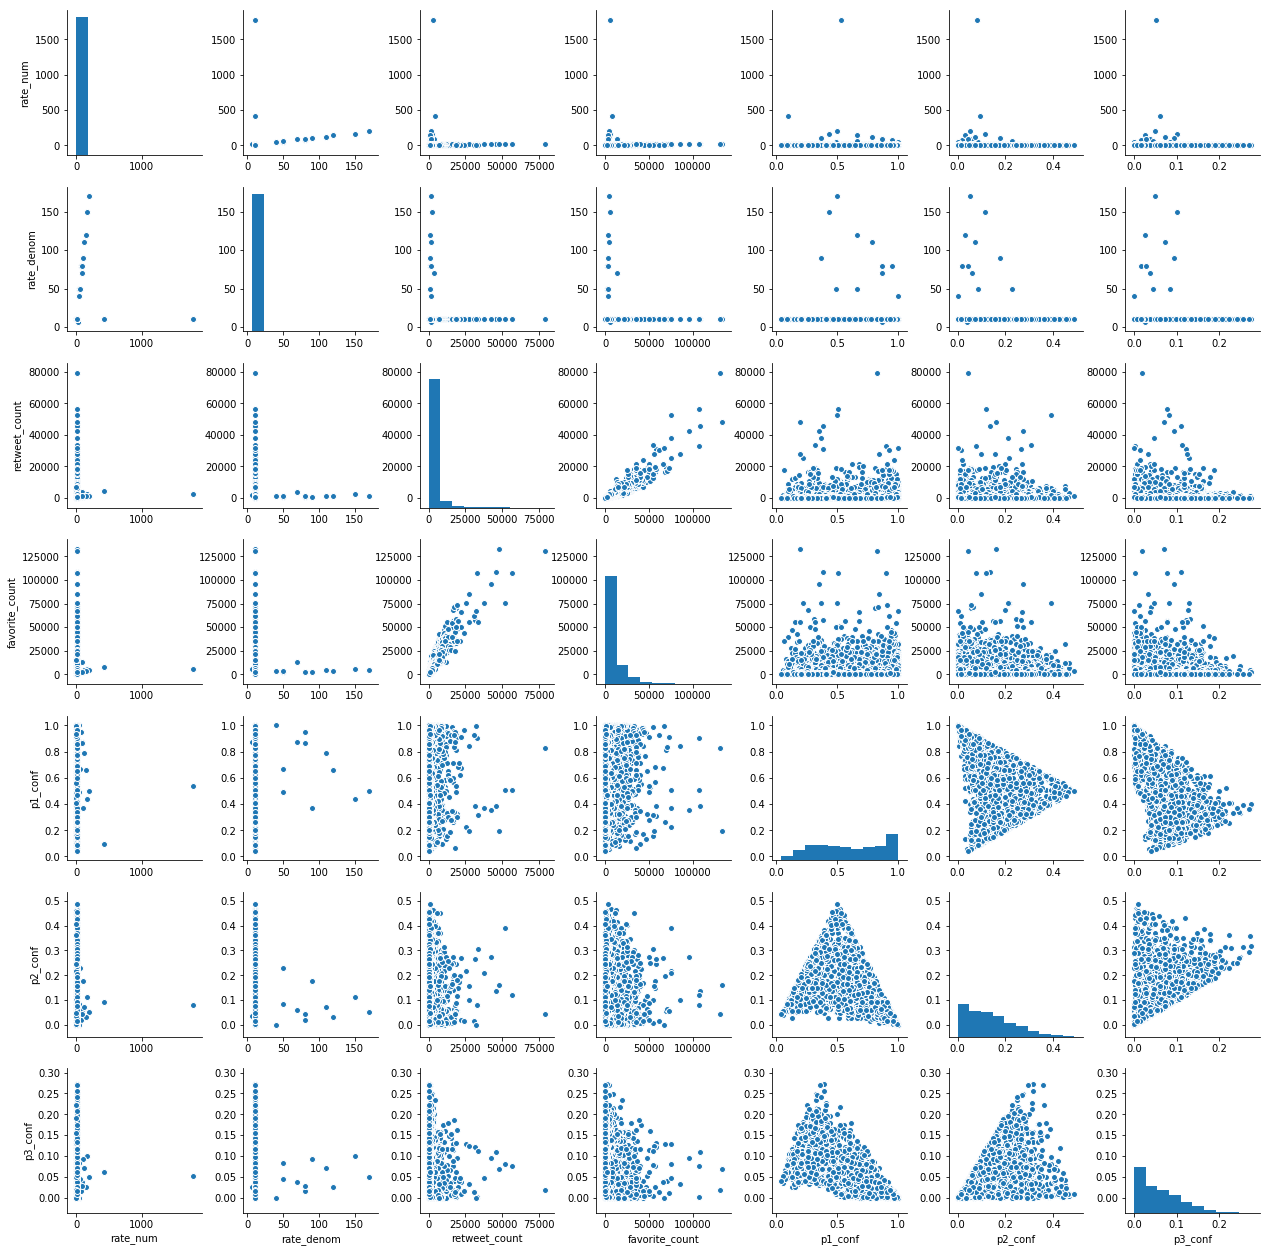

In [70]:
sns.pairplot(master_copy, vars=["rate_num", "rate_denom", "retweet_count", "favorite_count", "p1_conf", "p2_conf", "p3_conf"]);

#### Trends

In [71]:
# set these variables so the plotting code would be cleaner.
retweet_resamp = master_copy['retweet_count'].resample('1w').mean()
favorite_resamp = master_copy['favorite_count'].resample('1w').mean()

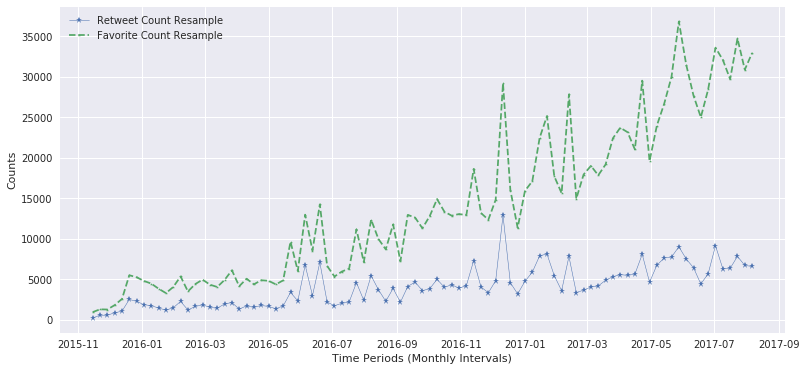

In [72]:
# plotting the resample of weekling favorite and retweet counts to show a smoother display over time.
sns.set(rc={'figure.figsize':(13, 6)})
fig, ax = plt.subplots()
ax.plot(retweet_resamp, marker='*', linestyle='-', linewidth=0.5, label='Retweet Count Resample')
ax.plot(favorite_resamp, marker='*', markersize=3, linestyle='--', label='Favorite Count Resample')
ax.set_ylabel('Counts')
ax.set_xlabel('Time Periods (Monthly Intervals)')
ax.legend();

#### The line graph above, was used by resampling the average counts of data, in weekly intervals, much like a moving average, which helps smooth out the graph and improve visibility of the trends.
#### As mentioned before, with this timeseries chart above, the favorite_count and retweet_count are positively correlated with one another. This is due to the fact that most people retweet 'tweets' that they like in order for others to see it. It is like 'free advertising' for the 'tweet' itself and shows people on your feed what you're interested in. It's a sharing feature when you want others to see something you've read/seen.
#### According to the chart, there are 3 spikes at specific times of year, those being, the middle of spring into summer, and then the Christmas/Holiday time. This is most likely due to the fact that people with dogs are more active in the warmer months, posting cute things their dog is doing outside. Also, during the holidays, they are more likely to share pics/etc about things they care about during this time i.e. their dogs.
#### The overall trend of the counts shows the popularity of this twitter page slowly growing overtime. If the number of followers were taken into account, it would most likely show a similar trend since the twitter account is getting more "air time."

In [73]:
tweets = np.array(master_copy.text)
my_list = []
for tweet in tweets:
    my_list.append(tweet.replace("\n",""))

In [74]:
mask = np.array(Image.open(requests.get('https://clipartix.com/wp-content/uploads/2016/06/Dog-bone-pink-print-dog-paw-print-transparent-background-paw-print-pink-clipart.jpg', stream=True).raw))
text = my_list

In [75]:
def gen_wc(text, mask):
    word_cloud = WordCloud(width = 500, height = 500, background_color='white', mask=mask).generate(str(text))
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='red')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
gen_wc(text, mask)